In [17]:
import pandas as pd
import numpy as np
import seaborn as sp
import matplotlib.pyplot as plt
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')

import statistics

In [2]:
train= pd.read_csv("train.csv")
test= pd.read_csv ("test.csv")

## Exploratory Data Analysis (EDA) ###

In [3]:
print("Column list with missing values in train:" ,train.columns[train.isna().sum() > 0])
print("Column list with missing values in test:" ,test.columns[test.isna().sum() > 0])

Column list with missing values in train: Index([], dtype='object')
Column list with missing values in test: Index([], dtype='object')


In [4]:
print("Column list with missing values in train:" ,train.columns[train.isna().sum() > 0])
print("Column list with missing values in test:" ,test.columns[test.isna().sum() > 0])

Column list with missing values in train: Index([], dtype='object')
Column list with missing values in test: Index([], dtype='object')


In [5]:
# Check if we have enough information for each entry
train.label.value_counts() 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [6]:
X_train = train.drop("label", axis=1)
y_train = train.label

In [7]:
print("Minimum  %d and maximum %d  values avaible in each pixel" %(train.min().min(),train.max().max()))

Minimum  0 and maximum 255  values avaible in each pixel


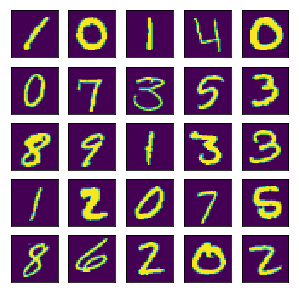

In [8]:
# Plot the data by converting it to 28x28 matrix
plt.figure(figsize=(5,5))
for digit_num in range(0,25):
    plt.subplot(5,5,digit_num+1)
    grid_data = X_train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none")
    plt.xticks([])
    plt.yticks([])

In [19]:
# Create a ensemble model to classification.
from sklearn.model_selection import train_test_split
def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)


from sklearn.ensemble import RandomForestClassifier
n_estimators_array = np.array([1,5,10,50,100,200,500])
n_samples = 10
n_grid = len(n_estimators_array)
score_array_mu =np.zeros(n_grid)
score_array_sigma = np.zeros(n_grid)
j=0
for n_estimators in n_estimators_array:
    score_array=np.zeros(n_samples)
    for i in range(0,n_samples):
        clf = RandomForestClassifier(n_estimators = n_estimators, n_jobs=1, criterion="gini")
        score_array[i] = evaluate_classifier(clf, train.iloc[0:1000], y_train.iloc[0:1000], 0.8)
    score_array_mu[j], score_array_sigma[j] = statistics.mean(score_array), statistics.stdev(score_array)
    j=j+1

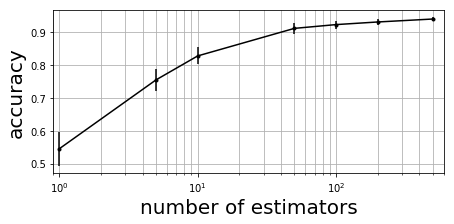

In [21]:
plt.figure(figsize=(7,3))
plt.errorbar(n_estimators_array, score_array_mu, yerr=score_array_sigma, fmt='k.-')
plt.xscale("log")
plt.xlabel("number of estimators",size = 20)
plt.ylabel("accuracy",size = 20)
plt.xlim(0.9,600)
plt.grid(which="both")

Feature ranking:
1. feature 0 (0.056520)
2. feature 379 (0.009305)
3. feature 410 (0.007518)
4. feature 407 (0.007359)
5. feature 434 (0.007228)
6. feature 598 (0.006769)
7. feature 351 (0.006511)
8. feature 517 (0.006462)
9. feature 406 (0.006430)
10. feature 348 (0.006301)


Text(0,0.5,'importance')

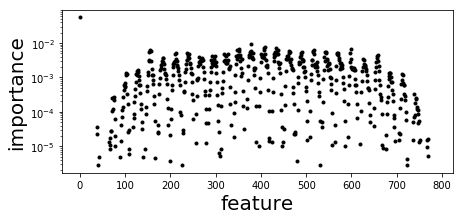

In [23]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances

plt.figure(figsize=(7,3))
plt.plot(indices[:],importances[indices[:]],'k.')
plt.yscale("log")
plt.xlabel("feature",size=20)
plt.ylabel("importance",size=20)

### Lets try to apply PCA on this to reduce the varibale count.

In [24]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [25]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

Text(0,0.5,'PC2')

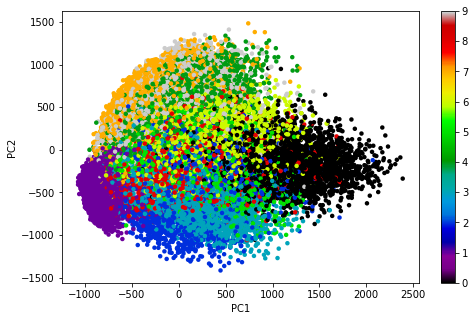

In [26]:
transform = pca.transform(X_train)

plt.figure(figsize=(8,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = y_train, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
plt.clim(0,9)

plt.xlabel("PC1")
plt.ylabel("PC2")

We can see that PCA has seperated the lables into visible clusters. This is with only 2 PCA vectors. Lets try and see how many PCAs are required to explain the varience.

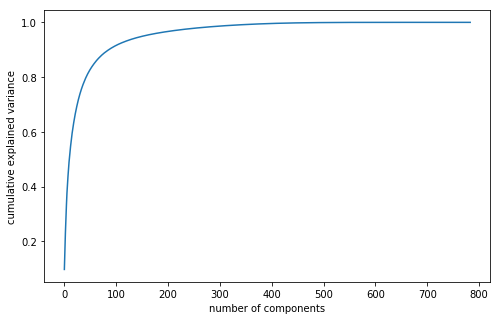

In [27]:
#Making the screeplot - plotting the cumulative variance against the number of components
fig = plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# looks like 100 variables are able to addess 90% of variaance while 200 is able to address 97% of variance.
# This is high number of features, lets use some other model to reduce the number.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,120,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    transform = pca.transform(train.iloc[0:1000])
    score_array[i] = evaluate_classifier(clf, transform, y_train.iloc[0:1000], 0.8)
    i=i+1

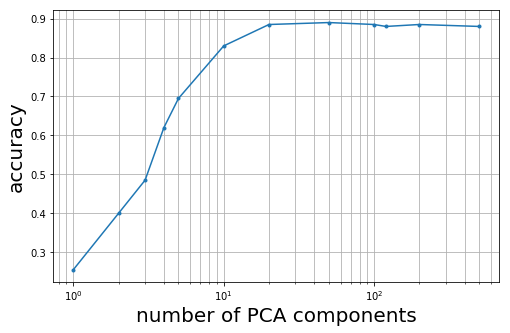

In [31]:
fig = plt.figure(figsize = (8,5))
plt.plot(n_components_array,score_array,'.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

20 variables are able to explain good amount of variance while 50 explains the peak

In [32]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=50)
df_train_pca = pca_final.fit_transform(X_train)
df_test_pca = pca_final.transform(test)

In [33]:
# Create a simple model to classification.
clf = KNeighborsClassifier()
clf.fit(df_train_pca, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
results=clf.predict(df_test_pca)

In [37]:
Submission = pd.DataFrame(columns=['ImageId', 'Label'])
Submission["Label"]= results
Submission["ImageId"]= Submission.index+1

In [39]:
Submission.to_csv("New_Result.csv",index=False)
print("Result is placed on storage")

Result is placed on storage
